In [18]:
%load_ext autoreload
%autoreload 2
%%time

#Imports
import geopandas as gpd
import numpy as np
import pandas as pd
import importlib

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


# Pour k-means
import data_weighted_kmeans

# Pour graph
import folium
import random


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load IRIS (slow, run once)

In [13]:
# Load data
# iris = gpd.read_file("data/CONTOURS-IRIS_2-1__SHP__FRA_2017-06-30/CONTOURS-IRIS/1_DONNEES_LIVRAISON_2016/CONTOURS-IRIS_2-1_SHP_LAMB93_FE-2016/CONTOURS-IRIS.shp")
iris=gpd.read_file("data/iris/hexagone2015.shp")

# Change projection
iris = iris.to_crs(epsg='4326')
iris.head()

population_2014 = pd.read_excel("data/population_iris/base-ic-evol-struct-pop-2014.xls", skiprows=4, header=1)



In [19]:
cantons = gpd.read_file("data/cantons/cantons_hexagone.shp")[['pop', 'atom', 'geometry']]
cantons.head()

,pop,atom,geometry
0,1479.0,1,"POLYGON ((2.344593389839741 48.85404991394893,..."
1,9372.0,2,"POLYGON ((2.349365804814235 48.86057567136368,..."
2,3424.0,3,"POLYGON ((2.339465868602756 48.86213531209341,..."
3,2825.0,4,"POLYGON ((2.331944969393235 48.86491285291057,..."
4,1500.0,5,"POLYGON ((2.33632021230595 48.86797138901755, ..."


In [18]:
iris.head()

,CODE_IRIS,p18,id,geometry,centroid_lng,centroid_lat
0,010010000,561.483333,010010000,"POLYGON ((4.903076899773672 46.15797713940923,...",4.928099,46.151218
1,010020000,186.581197,010020000,"POLYGON ((5.44437941248567 46.01725777685667, ...",5.426115,46.009255
2,010040102,2827.784991,010040102,"POLYGON ((5.352800501160297 45.95545470498314,...",5.344648,45.953107
3,010040202,3467.038058,010040202,"POLYGON ((5.352800501160297 45.95545470498314,...",5.381566,45.961260
4,010040101,1512.562059,010040101,"POLYGON ((5.3283673140708 45.95870273871893, 5...",5.339962,45.968408


## Parameters

In [20]:
import ipywidgets as widgets
widgets.IntSlider(
    value=7,
    min=0,
    max=10,
    step=1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

IntSlider(value=7, continuous_update=False, description='Test:', max=10)

In [4]:
# interact(f,x=10)

NameError: name 'f' is not defined

In [21]:
# Number of clusters
k=335
k_metropole = 320
departement="95"
iris.head()

NameError: name 'iris' is not defined

## Filter IRIS

In [6]:
# iris_filtered = iris[iris["CODE_IRIS"].str.startswith(departement)].copy() # only one department
iris_filtered = iris # all France
iris_filtered.head()

,INSEE_COM,NOM_COM,IRIS,CODE_IRIS,NOM_IRIS,TYP_IRIS,geometry
0,72191,Mayet,0000,721910000,Mayet,Z,POLYGON ((0.3024091862497977 47.79700665751155...
1,77248,Lesches,0000,772480000,Lesches,Z,"POLYGON ((2.805604238863105 48.91734812113162,..."
2,51426,Péas,0000,514260000,Péas,Z,"POLYGON ((3.763474413052397 48.72358442383026,..."
3,81199,Padiès,0000,811990000,Padiès,Z,"POLYGON ((2.394721146216618 44.03456275817786,..."
4,59225,Feignies,0102,592250102,Sud,H,"POLYGON ((3.948536216024017 50.29481618777179,..."


## Add Population

In [7]:
population_2014["CODE_IRIS"] = population_2014["IRIS"]
iris_filtered = iris_filtered.merge(population_2014, how='inner', on=["CODE_IRIS"])


## Calculate clusters

In [87]:
# Get centroids
iris_filtered.loc[:, 'centroid_lng'] = iris_filtered["geometry"].centroid.apply(lambda x: x.x)
iris_filtered.loc[:, 'centroid_lat'] = iris_filtered["geometry"].centroid.apply(lambda x: x.y)

In [17]:
iris.loc[:, 'centroid_lng'] = iris["geometry"].centroid.apply(lambda x: x.x)
iris.loc[:, 'centroid_lat'] = iris["geometry"].centroid.apply(lambda x: x.y)

In [22]:
cantons.loc[:, 'centroid_lng'] = cantons["geometry"].centroid.apply(lambda x: x.x)
cantons.loc[:, 'centroid_lat'] = cantons["geometry"].centroid.apply(lambda x: x.y)

In [12]:
# Set other needed columns
iris_filtered.loc[:, 'departement_iris'] = "75"


In [7]:
%%time
import importlib
importlib.reload(data_weighted_kmeans)


points = []

# for idx, row in iris.iterrows():
#     points.append({"coords": np.array([float(row['centroid_lng']), float(row['centroid_lat'])]), \
#                    "w": int(row['p18']), "CODE_IRIS": row['CODE_IRIS']})
    
for idx, row in cantons.iterrows():
    points.append({"coords": np.array([float(row['centroid_lng']), float(row['centroid_lat'])]), \
                   "w": int(row['pop']), "atom": row['atom']})
    
# for idx, row in iris_filtered.iterrows():
#     points.append({"coords": np.array([float(row['centroid_lng']), float(row['centroid_lat'])]), \
#                    "w": int(row['P14_POP']), "zip": row['CODE_IRIS'], "state": row["departement_iris"]})

print(len(points))
# points = random.sample(points,40000)
# centers = data_weighted_kmeans.equally_spaced_initial_clusters(points, k)
centers = data_weighted_kmeans.randomize_initial_cluster(points, k_metropole)


points, centers, it_num = data_weighted_kmeans.kmeans_evolution_weighted(points, centers, k_metropole, it_max=1000000, stop_criteria=2.5, weight_step_scale=20)

points_df = pd.DataFrame.from_dict(points)
# points_df["CODE_IRIS"] = points_df["ref"]
# points_df["coords"] = "aaa"
# points_df.head()

result = cantons.merge(points_df, how='inner', on=['atom', 'atom'])
# result.head()
# result = result[['atom','geometry','c', 'pop']]

# clean the data
valid_cantons = result['geometry'].is_valid
print('invalid cantons:', np.where([not v for v in valid_cantons])[0])
result = result.iloc[np.where(valid_cantons)[0]]

result.to_file("cantons_decoupage2-5")

2116
Goal Population:  197154.853125
128.1007280434983
102.29238054240207
89.82574257425743
78.58390012914334
67.83633232888506
68.83874300473525
69.78097287989668
22.489971707010373
30.988737763146496
22.628890286073563
21.466614272241433
19.964710697892
18.80560184779113
21.54968862380493
20.23290354647253
20.060301928990775
20.459239586245456
24.52270058708415
17.511148670610414
18.330039654163688
17.49650046588225
16.968601703178834
16.935386223567587
15.326662165987935
13.61997009686017
18.732231679009615
13.61997009686017
11.725801209126958
11.423345919505707
9.681760607979735
19.088239555662884
19.768606616759236
17.66566046848587
14.577348466553973
16.032649118570394
17.185679787490944
17.359502535619416
14.431562424535137
16.20915750915751
21.988449328449327
25.755067155067156
33.51006181027913
20.690775175078482
20.43149773153305
15.002615009647608
18.707152895924256
18.707152895924256
17.48069383830165
21.244840594718543
20.915748206228272
21.433205118721798
42.9387528663362

KeyError: 'atom'

In [15]:
points_df.head()

,c,canton,coords,w,atom
0,30,1,"[2.33491032923, 48.8606501345]",1479,1
1,30,2,"[2.34489885828, 48.8622891073]",9372,2
2,30,3,"[2.3363089189, 48.8646599774]",3424,3
3,30,4,"[2.32858166473, 48.8670185901]",2825,4
4,30,5,"[2.3334318081, 48.8693066376]",1500,5


In [17]:
result = cantons.merge(points_df, how='inner', on=['atom', 'atom'])
# result.head()
result = result[['atom','geometry','c', 'pop']]

# clean the data
valid_cantons = result['geometry'].is_valid
print('invalid cantons:', np.where([not v for v in valid_cantons])[0])
result = result.iloc[np.where(valid_cantons)[0]]

result.to_file("cantons_decoupage2-5")

invalid cantons: []


In [75]:
result = iris.merge(points_df, how='inner', on=['CODE_IRIS', 'CODE_IRIS'])
result = result[['iris','geometry','c']]
valid_iris = result['geometry'].is_valid
print('invalid iris:', np.where([not v for v in valid_iris])[0])
result = result.iloc[np.where(valid_iris)[0]]

# invalid iris: [  158  1923  2007  2200  2294  3215  3687  5385  5487  5581  5633  7443
#   8090  8947  9757  9793 11835 12057 12542 12746 13436 13878 14135 14640
#  15778 16368 16726 16790 16913 17170 17750 18201 18573 18842 19635 20621
#  21348 21383 21604 21983 22871 22946 23144 23217 25567 25814 27439 27872
#  28091 28426 28432 28770 29103 29272 29279 29622 29624 31416 31864 32169
#  33678 33969 34221 34969 36001 36094 36204 36239 36241 37104 38199 38290
#  38555 40395 40424 41068 41260 42278 44473 45258 45281 45957 46334 46640]

result.to_file("iris_decoupage1-5")

invalid iris: [  158  1923  2007  2200  2294  3215  3687  5385  5487  5581  5633  7443
  8090  8947  9757  9793 11835 12057 12542 12746 13436 13878 14135 14640
 15778 16368 16726 16790 16913 17170 17750 18201 18573 18842 19635 20621
 21348 21383 21604 21983 22871 22946 23144 23217 25567 25814 27439 27872
 28091 28426 28432 28770 29103 29272 29279 29622 29624 31416 31864 32169
 33678 33969 34221 34969 36001 36094 36204 36239 36241 37104 38199 38290
 38555 40395 40424 41068 41260 42278 44473 45258 45281 45957 46334 46640]


In [73]:
result.head()

,iris,geometry,c
0,010010000,"POLYGON ((4.903076899773672 46.15797713940923,...",52
1,010020000,"POLYGON ((5.44437941248567 46.01725777685667, ...",83
2,010040102,"POLYGON ((5.352800501160297 45.95545470498314,...",83
3,010040202,"POLYGON ((5.352800501160297 45.95545470498314,...",83
4,010040101,"POLYGON ((5.3283673140708 45.95870273871893, 5...",83


In [ ]:
points_df = pd.DataFrame.from_dict(points)
points_df["CODE_IRIS"] = points_df["zip"]
points_df["coords"] = "aaa"
# points_df.head()

result = iris_filtered.merge(points_df, how='inner', on=['CODE_IRIS', 'CODE_IRIS'])
# result.head()

# clean the data
valid_iris = result['geometry'].is_valid
print('invalid IRIS:', np.where([not v for v in valid_iris])[0])
result = result.iloc[np.where(valid_iris)[0]]

# result.to_file("decoupage")

# Join the IRIS based on district
simplified_map = result.dissolve(by='c')
simplified_map.head()

# Show map
simplified_map["colour"] = ["#%06x" % random.randint(0, 0xFFFFFF) for i in range(0,k)]   #["#FF2D00", "#3EA707", "#F9FE00", "#000EFE", "#00FE51", "#0000FF", "#FF33FF", "#444444", "#4400FF", "#004444"]

# mapa = folium.Map([48.866607, 2.346882],
#                   zoom_start=13,
mapa = folium.Map([46.575859, 0.290518],
                  zoom_start=9,
                  tiles='cartodbpositron')


points = folium.features.GeoJson(simplified_map,  style_function=lambda feature: { 'fillColor': feature['properties']['colour'],
        'color' : "#000000",
        'weight' : 1,
        'fillOpacity' : 0.5,
        }
)
mapa.add_children(points)

for i in range(0,len(centers)):
    center = centers[i]
    folium.Marker([center["coords"][1], center["coords"][0]], popup="{idx} : {pop}".format(idx=i, pop=center["pop"])).add_to(mapa)

mapa


invalid IRIS: [25159]


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:34: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.


Ratio :  3.86
c
0       8640.769593
1       7148.911559
2       7212.002092
3       9561.000000
4       7384.365993
5       7727.150515
6       6727.444691
7       8714.028108
8      12911.992784
9       8657.107765
10      6626.013951
11      8093.181172
12      8675.811715
13      5418.588456
14      7107.731586
15      8473.939142
16      7670.327154
17      7373.490880
18      8272.379565
19      6590.353589
20      9950.000000
21      8786.816798
22      7570.421618
23      8315.821984
24     11106.463858
25      8489.326565
26      8612.821708
27      8675.216165
28      8411.000000
29      6278.246067
           ...     
120     7588.539789
121     7655.889199
122     8543.292916
123    10136.000000
124     7971.997908
125     7341.883736
126     7814.166891
127     8443.281273
128     7990.519099
129     8348.309575
130     8275.084074
131    10503.000000
132     4069.073750
133     7954.427000
134     8093.102626
135     7203.083991
136    11539.843879
137     8328.000000
138 

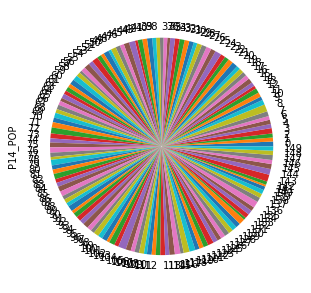

In [53]:
pops = result.groupby("c").sum()["P14_POP"]
print("Ratio : ", round(pops.max() / pops.min(),2))
print(pops)
plot = pops.plot.pie(figsize=(5, 5))


In [111]:
min(pops)

148082.87988452858

In [371]:
result.columns

Index(['INSEE_COM', 'NOM_COM', 'IRIS_x', 'CODE_IRIS', 'NOM_IRIS', 'TYP_IRIS_x',
       'geometry', 'IRIS_y', 'REG', 'DEP', 'UU2010', 'COM', 'LIBCOM', 'TRIRIS',
       'GRD_QUART', 'LIBIRIS', 'TYP_IRIS_y', 'MODIF_IRIS', 'LAB_IRIS',
       'P14_POP', 'P14_POP0002', 'P14_POP0305', 'P14_POP0610', 'P14_POP1117',
       'P14_POP1824', 'P14_POP2539', 'P14_POP4054', 'P14_POP5564',
       'P14_POP6579', 'P14_POP80P', 'P14_POP0014', 'P14_POP1529',
       'P14_POP3044', 'P14_POP4559', 'P14_POP6074', 'P14_POP75P',
       'P14_POP0019', 'P14_POP2064', 'P14_POP65P', 'P14_POPH', 'P14_H0014',
       'P14_H1529', 'P14_H3044', 'P14_H4559', 'P14_H6074', 'P14_H75P',
       'P14_H0019', 'P14_H2064', 'P14_H65P', 'P14_POPF', 'P14_F0014',
       'P14_F1529', 'P14_F3044', 'P14_F4559', 'P14_F6074', 'P14_F75P',
       'P14_F0019', 'P14_F2064', 'P14_F65P', 'C14_POP15P', 'C14_POP15P_CS1',
       'C14_POP15P_CS2', 'C14_POP15P_CS3', 'C14_POP15P_CS4', 'C14_POP15P_CS5',
       'C14_POP15P_CS6', 'C14_POP15P_CS7', 'C14_